In [2]:
%%writefile sentiment_models.py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential  # We use Keras API for training model
from tensorflow.keras.layers import (
    Embedding, SimpleRNN, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Definition of Core Functions
def load_and_preprocess(filepath):
    """
    The data is loaded and subjected to basic preprocessing, mapping, and visualization; subsequently,
    the text is converted into sequences and split into training and testing sets
    Return: X_train, X_test, y_train, y_test, y_train_oh, y_test_oh, vocab_size, maxlen
    """
    # 1. Load the data
    df = pd.read_csv(
        filepath,
        sep='\t',
        header=None,
        names=['ID', 'TOPIC', 'SENTIMENT', 'TWEET'],
        quoting=3,
        engine='python'
    )

    # 2. Display the original sentiment distribution
    print("===== Original Sentiment Distribution (Before Remapping) =====")
    print(df['SENTIMENT'].value_counts())  # Count the occurrences of each sentiment label

    # 3. Plot the original sentiment distribution
    # Plot a bar chart to visualize the frequency of each label
    plt.figure(figsize=(6,4))
    sns.countplot(x='SENTIMENT', data=df, order=sorted(df['SENTIMENT'].unique()))
    plt.title("Original Sentiment Distribution")
    plt.show()

    # 4. Display a sample of the dataset (first five rows)
    #print("\n===== Sample of the data (first 5 rows) =====")
    #print(df.head())

    # 5. Map the sentiment labels to the range [0–4]
    #    -2 -> 0, -1 -> 1,  0 -> 2,  1 -> 3,  2 -> 4
    label_map = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
    df['SENTIMENT'] = df['SENTIMENT'].map(label_map)

    # 6. Prepare for tokenization and sequence conversion
    # Convert the text in the TWEET column to string format, then tokenize and transform it into integer sequences using a tokenizer
    tweets = df['TWEET'].astype(str)
    labels = df['SENTIMENT'].values

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets)
    sequences = tokenizer.texts_to_sequences(tweets)
    maxlen = max(len(seq) for seq in sequences)  # Retrieve the longest sequence among all tweets

    # Apply post-padding to ensure all input sequences have the same length
    padded_seq = pad_sequences(sequences, maxlen=maxlen, padding='post')
    vocab_size = len(tokenizer.word_index) + 1

    # 7. Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        padded_seq,
        labels,
        test_size=0.2, # 20% for testing
        random_state=42
    )
    y_train_oh = to_categorical(y_train, num_classes=5)
    y_test_oh = to_categorical(y_test, num_classes=5)

    return X_train, X_test, y_train, y_test, y_train_oh, y_test_oh, vocab_size, maxlen


# ========== Build a basic RNN model ==========
def train_simple_rnn(X_train, y_train_oh, vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 50, input_length=maxlen), # Word embedding layer (output size: 50)
        SimpleRNN(50, activation='tanh'), # Activation function: tanh
        Dense(5, activation='softmax') # Output probability distribution over 5 classes
    ])
    # Training for 5 epochs with a batch size of 64 and a validation split of 20%
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_oh, epochs=5, batch_size=64, validation_split=0.2)
    return model


# ========== Bidirectional LSTM Model ==========
def train_bilstm(X_train, y_train_oh, vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 32, input_length=maxlen), # Embedding dimension: 32
        Bidirectional(LSTM(64, return_sequences=True)), # Number of hidden units: 64
        Bidirectional(LSTM(64)),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_oh, epochs=5, batch_size=64, validation_split=0.2)
    return model


# ========== Simple 1D Convolutional Neural Network ==========
def train_cnn(X_train, y_train_oh, vocab_size, maxlen):
    model = Sequential([
        Embedding(vocab_size, 50, input_length=maxlen),
        Conv1D(64, 3, activation='relu'), # Convolutional layer with 64 filters and a kernel size of 3
        GlobalMaxPooling1D(),        # Apply max pooling over the time dimension
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train_oh, epochs=5, batch_size=64, validation_split=0.2) # Batch size: 64
    return model


def evaluate_model(model, X_test, y_test):
    # Make predictions and generate the classification report
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues') # Perform Visualization
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Overwriting sentiment_models.py


===== Example of the data after custom cleaning and augmentation =====
                   id        topic  label_num  \
0  681563394940473347  amy schumer         -1   
1  675847244747177984  amy schumer         -1   
2  672827854279843840  amy schumer         -1   
3  671502639671042048  amy schumer         -1   
4  677359143108214784  amy schumer         -1   

                                           tweet_raw           label  \
0  @MargaretsBelly Amy Schumer is the stereotypic...  WEAKLYNEGATIVE   
1  @dani_pitter I mean I get the hype around JLaw...  WEAKLYNEGATIVE   
2  Amy Schumer at the #GQmenoftheyear2015 party i...  WEAKLYNEGATIVE   
3  Amy Schumer may have brought us Trainwreck, bu...  WEAKLYNEGATIVE   
4  I just think that sports are stupid &amp;anyon...  WEAKLYNEGATIVE   

                                               tweet  \
0  Amy Schumer is the stereotypical 1st world Lac...   
1  I mean I get the hype around JLaw I may not li...   
2  Amy Schumer at the GQmenofthey

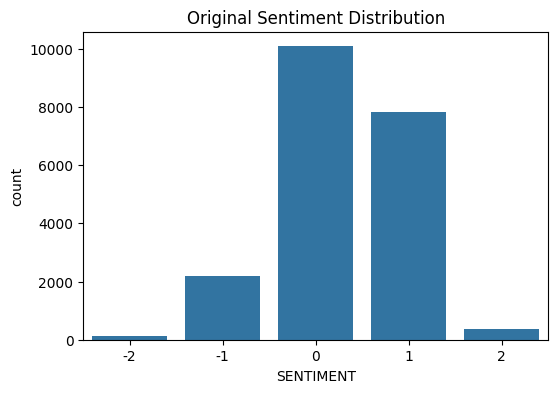

In [3]:
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import previously defined functions from sentiment_models
from sentiment_models import (
    load_and_preprocess,
    train_simple_rnn,
    train_bilstm,
    train_cnn,
    evaluate_model
)

# ============== 1. Data loading and cleaning ==============
# The same file is read in, followed by customized cleaning, scoring, and splitting operations
data_path = "/content/SemEval2017-task4-dev.subtask-CE.english.INPUT.txt"

df = pd.read_csv(
    data_path,
    sep='\t',
    header=None,
    names=['id', 'topic', 'label_num', 'tweet_raw'],
)

# Mapping between numerical and string sentiment labels
label_map = {
    -2: "STRONGLYNEGATIVE",
    -1: "WEAKLYNEGATIVE",
     0: "NEUTRAL",
     1: "WEAKLYPOSITIVE",
     2: "STRONGLYPOSITIVE"
}
df['label'] = df['label_num'].map(label_map)  # Convert numeric labels to human-readable strings

def basic_text_cleaning(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+", "", text)  # "Remove user mentions @someone
    text = re.sub(r"#", "", text)     # Remove topic markers #
    text = re.sub(r"[^A-Za-z0-9(),!?\'`]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['tweet'] = df['tweet_raw'].astype(str).apply(basic_text_cleaning)

# For compatibility with BERT's input format, each tweet is combined with its corresponding topic into a single string
df['input_text'] = df.apply(
    lambda row: f"[TOPIC] {row['topic']} [SEP] {row['tweet']}",
    axis=1
)

# ============== 2. Sentiment lexicon augmentation ==============
# We use a simple sentiment lexicon for scoring here
senti_lexicon = {
    "love": 2, "like": 1, "good": 1,
    "hate": -2, "bad": -1, "horrible": -2
}
def lexicon_score(sentence):
    words = sentence.lower().split()
    score = 0
    for w in words:
        if w in senti_lexicon:
            score += senti_lexicon[w]
    return score

df['lexicon_score'] = df['tweet'].apply(lexicon_score) # Store the score in df['lexicon_score']

# ============== 3. Data splitting and handling of class imbalance ==============
le = LabelEncoder()
df['label_id'] = le.fit_transform(df['label'])  # 转成0~4

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label_id']
)

# Compute class weights for use in weighted cross-entropy loss
train_labels_array = train_df['label_id'].to_numpy()
class_counts = Counter(train_labels_array)  # Count the occurrences of each class in the training set
num_samples = len(train_labels_array)
num_classes = len(class_counts)
weights = [
    num_samples / (num_classes * class_counts[i])
    for i in range(num_classes)
]
class_weights = torch.tensor(weights, dtype=torch.float)

print("===== Example of the data after custom cleaning and augmentation =====")
print(df.head())

# Directly use the previously defined function: load_and_preprocess
# Read the file from the same data_path and apply its internal preprocessing logic
print("\n\n===== Utilizing the original load_and_preprocess(...) function for training =====")
X_train, X_test, y_train, y_test, y_train_oh, y_test_oh, vocab_size, maxlen = load_and_preprocess(data_path)


==== Simple RNN ====
Epoch 1/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4622 - loss: 1.1664 - val_accuracy: 0.4808 - val_loss: 1.0750
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.4912 - loss: 1.0607 - val_accuracy: 0.4808 - val_loss: 1.0747
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5842 - loss: 0.9964 - val_accuracy: 0.4926 - val_loss: 1.1272
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.7529 - loss: 0.7042 - val_accuracy: 0.4886 - val_loss: 1.3307
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8509 - loss: 0.4686 - val_accuracy: 0.4408 - val_loss: 1.5930
Evaluating Simple RNN...
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.15      0.18      0.16       395
           2       0.54      0.44      0.48      2024
           3       0.44      0.55      0.49      1589

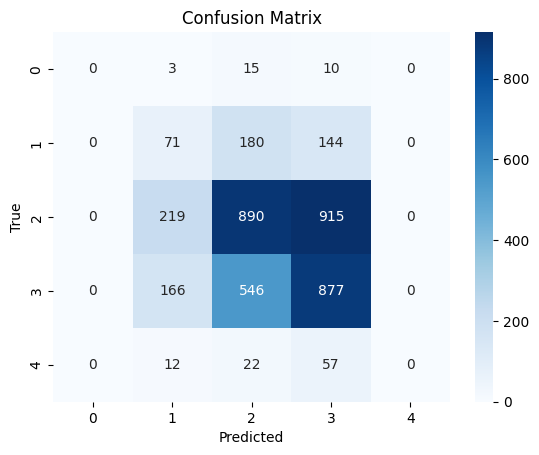


==== BiLSTM ====
Epoch 1/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.4896 - loss: 1.1230 - val_accuracy: 0.6001 - val_loss: 0.9414
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 148ms/step - accuracy: 0.6708 - loss: 0.8108 - val_accuracy: 0.6125 - val_loss: 0.8845
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 28s 135ms/step - accuracy: 0.8033 - loss: 0.5347 - val_accuracy: 0.6007 - val_loss: 0.9991
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - accuracy: 0.8970 - loss: 0.3190 - val_accuracy: 0.5956 - val_loss: 1.2647
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 29s 141ms/step - accuracy: 0.9366 - loss: 0.1972 - val_accuracy: 0.5819 - val_loss: 1.4461
Evaluating BiLSTM...
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step
              precision    recall  f1-score   support

           0       0.06      0.04      0.04        28
           1       0.36      0.39      0.38       395
           2       0.62      0.70      0.66      2024
           3       0.62      0.54      0.58      158

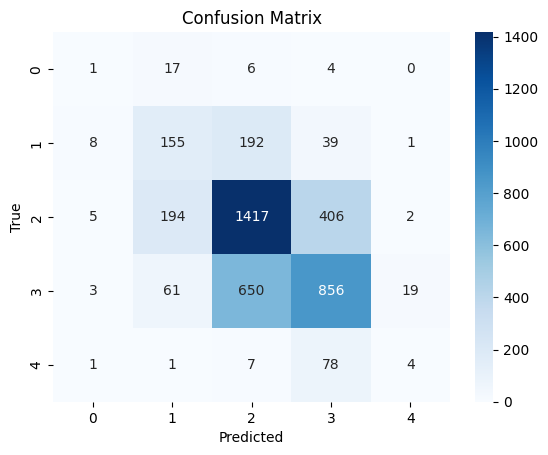


==== CNN ====
Epoch 1/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4775 - loss: 1.1798 - val_accuracy: 0.5862 - val_loss: 0.9693
Epoch 2/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6471 - loss: 0.8631 - val_accuracy: 0.6256 - val_loss: 0.8889
Epoch 3/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7985 - loss: 0.5859 - val_accuracy: 0.6095 - val_loss: 0.9275
Epoch 4/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9021 - loss: 0.3276 - val_accuracy: 0.5904 - val_loss: 1.0375
Epoch 5/5
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9470 - loss: 0.1959 - val_accuracy: 0.5916 - val_loss: 1.1308
Evaluating CNN...
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.39      0.24      0.30       395
           2       0.61      0.76      0.68      2024
           3       0.62      0.53      0.57      1589
           4   

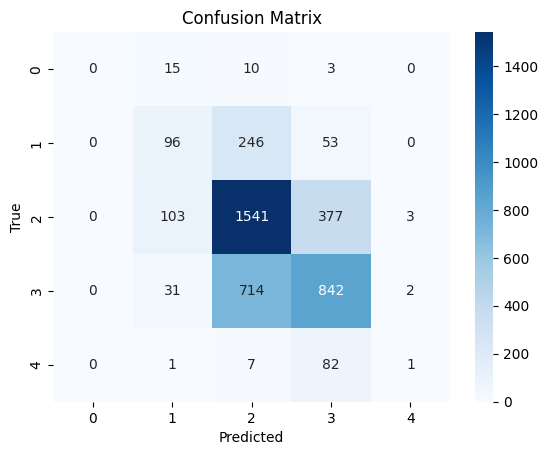

In [4]:
# ================================
#        1) Simple RNN
# ================================
print("\n==== Simple RNN ====")
model_rnn = train_simple_rnn(X_train, y_train_oh, vocab_size, maxlen)
print("Evaluating Simple RNN...")
evaluate_model(model_rnn, X_test, y_test)

# ================================
#        2) BiLSTM
# ================================
print("\n==== BiLSTM ====")
model_bilstm = train_bilstm(X_train, y_train_oh, vocab_size, maxlen)
print("Evaluating BiLSTM...")
evaluate_model(model_bilstm, X_test, y_test)

# ================================
#        3) CNN
# ================================
print("\n==== CNN ====")
model_cnn = train_cnn(X_train, y_train_oh, vocab_size, maxlen)
print("Evaluating CNN...")
evaluate_model(model_cnn, X_test, y_test)